# Broadway Musical Success Prediction

This project aims to predict the success of a Broadway Musicals based off of data gathered within the first year of performance.

In [82]:
## Run in Python 3 
from __future__ import print_function, division
import os
import sys
import requests
import urllib
from functools import reduce

## The Standards
import pylab as pl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
pl.rcParams['font.size'] = 18

## Statistical Modelling
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.datasets.longley import load
import sklearn.preprocessing as preprocessing
from sklearn.ensemble  import RandomForestRegressor as rfr
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mod', 'load', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [48]:
def corr_matrix(df):
    f, ax = pl.subplots(figsize=(10, 8))
    corr = df.corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [197]:
def feature_importance(X, y):
    model = LinearRegression()
    model.fit(X, y)
    importance = model.coef_
#     for i,v in enumerate(importance):
#         print('Feature: %0d, Score: %.5f' % (i,v))
#     plt.bar([x for x in range(len(importance))], 
#                importance)
#     plt.title('Feature Importance')
#     plt.ylabel('Score', size=13)
#     plt.show()
    print(pd.Series(model.coef_, index=X.columns)
   .nlargest(20)
   .plot(kind='barh' , title = 'Feature Importance Scores' ))
    a = pd.Series(model.coef_, index=X.columns)
    return a[a>0].index

In [220]:
def fit_linear_regression(y_var, var_lists):
    df.sort_values([y_var],inplace=True)

    ols_results = pd.DataFrame(
        index=[['rsquared','Intercept']+list(df.columns) ],
        columns = range(len(var_lists)))

    for n in range(len(var_lists)):
        mod = smf.ols(formula = 
            '{} ~ {}'.format(y_var,
                             reduce(lambda x, y: x + " + " + y,
                            [i for i in var_lists[n]]))
                  , data=df)
        results = mod.fit()
        ols_results[n]['rsquared'] = results.rsquared
        for i in results.params.index:
            ols_results[n][i] = results.params[i]

    print(ols_results.dropna(how='all') )

    #results1.summary()

In [15]:
df = pd.read_excel('Data/2010-2019_broadway_musical_data.xlsx')
df = df.set_index('ref')
df['more_than_year'] = df['weeks'].apply(lambda x: 
                                        1 if x > 52 else 0)

## Shows by ref #

In [17]:
for ref in df.index:
    print(ref, ' : ' , df['Title of Show'][ref])

112  :  Oliver!
134  :  The Book of Mormon
99  :  Kinky Boots
86  :  Aladdin
89  :  Beautiful: The Carol King Musical
13  :  Hamilton
98  :  Matilda the Musical
25  :  Waitress
35  :  Dear Evan Hansen
39  :  Come From Away
120  :  Once
127  :  Spider-Man Turn Off The Dark
85  :  Les Misérables
118  :  Newsies
90  :  A Gentleman's Guide to Love and Murder
52  :  Frozen
46  :  Anastasia
54  :  Mean Girls
102  :  Cinderella
16  :  On Your Feet!
97  :  Motown the Musical
10  :  Something Rotten!
95  :  Pippin
34  :  A Bronx Tale the Musical
4  :  An American In Paris
30  :  Cats
48  :  The Band's Visit
8  :  Fun Home
81  :  Hedwig and the Angry Inch
6  :  Finding Neverland
129  :  Sister Act
44  :  Hello, Dolly!
135  :  Priscilla Queen of the Desert
132  :  Anything Goes
56  :  My Fair Lady
7  :  The King and I
108  :  Annie
133  :  How to Succeed in Business Without Really Trying
114  :  Nice Work If You Can Get It
49  :  Once on This Island
19  :  The Color Purple
20  :  Fiddler on the R

In [18]:
cols_to_drop = ['Title of Show', 'open', 'close',
        'tourweeks', 'touropen', 'tourclose', 'tour', 'tourgross', 
        'intl','intlweeks', 'intlopen', 'intlclose', 'intlnum',
        'celeb','Producer', 'capcost','cast','Social',  
        'popen','pclose','pgross','pavggrosspoten', 
        'fopen', 'fclose','fgross','favggrosspoten','ftotalseats',
        'tweeks','tnumseats', 'ttotalseats','tnum']
df = df.drop(columns=cols_to_drop)

In [19]:
cols_to_test = ['num','numseats']

In [91]:
df = df.dropna(axis = 0  )#, subset = ['weeks','favggross','tonynom'])

In [21]:
df = df[df['tonynom'] != '*']
df = df[df['pweeks'] != '*']

In [22]:
for c in df.columns:
    df[c] = df[c].astype(float)

In [234]:
df[df.columns[:14]].describe()

,weeks,tonynom,tonywin,bestnom,bestwin,revival,original,family,jukebox,based,westend,bway,pweeks,pavggross
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,1.020000e+02
mean,59.528347,4.598039,1.205882,0.401961,0.117647,0.333333,0.666667,0.196078,0.088235,0.578431,0.058824,0.941176,3.627451,5.784465e+05
std,76.368520,4.259549,2.330760,0.492715,0.323781,0.473732,0.473732,0.398989,0.285037,0.496249,0.236456,0.236456,2.563729,2.844938e+05
min,2.714286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.113072e+05
25%,13.571429,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,3.443748e+05
50%,36.785714,3.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,3.000000,5.484690e+05
75%,72.175357,8.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,4.000000,7.291825e+05
max,466.430000,16.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,25.000000,1.360588e+06


In [235]:
df[df.columns[14:]].describe()

,pnumseats,ptotalseats,ppercentseats,pnum,fweeks,favggross,fnumseats,fpercentseats,fnum,tgross,tavggross,tavggrosspoten,tpercentseats,more_than_year
count,102.000000,1.020000e+02,102.000000,102.000000,102.000000,1.020000e+02,102.000000,102.000000,102.000000,1.020000e+02,1.020000e+02,102.000000,102.000000,102.000000
mean,26995.470588,9.068537e+04,0.876765,24.245098,32.941176,7.582252e+05,284290.852941,0.808627,258.088235,6.486181e+07,7.230610e+05,0.598949,0.808431,0.362745
std,31412.332796,6.097292e+05,0.136796,18.441471,18.735693,3.652195e+05,200199.231565,0.136040,150.185173,1.113764e+08,3.735858e+05,0.212265,0.118211,0.483166
min,957.000000,9.570000e+02,0.000000,1.000000,4.000000,1.483563e+05,24122.000000,0.480000,26.000000,1.209478e+06,1.492661e+05,0.196700,0.520000,0.000000
25%,15366.500000,1.883200e+04,0.820000,17.000000,15.000000,5.064305e+05,89289.250000,0.720000,113.000000,8.387313e+06,4.666444e+05,0.451300,0.730000,0.000000
50%,22073.000000,2.636650e+04,0.915000,22.000000,38.500000,7.266409e+05,277024.500000,0.820000,303.500000,2.858249e+07,7.093264e+05,0.585800,0.820000,0.000000
75%,31270.750000,3.436350e+04,0.970000,26.750000,52.000000,9.843260e+05,449417.000000,0.920000,414.000000,6.733917e+07,8.914220e+05,0.717950,0.900000,1.000000
max,314578.000000,6.179280e+06,1.030000,173.000000,52.000000,1.745930e+06,723672.000000,1.030000,417.000000,6.596044e+08,2.674357e+06,1.150900,1.020000,1.000000


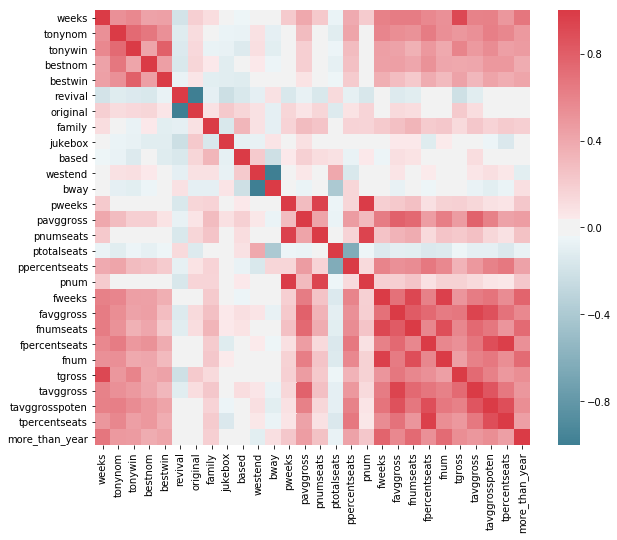

In [93]:
corr_matrix(df)

In [65]:
y_vars = ['weeks', 'tgross',
       'tavggross', 'tavggrosspoten', 'tpercentseats','more_than_year']

In [238]:
first_run = ['tonynom', 'tonywin', 'bestnom', 'bestwin',
        'pweeks', 'pavggross', 'pnumseats', 'ppercentseats',
         'fweeks', 'favggross',  'fnumseats', 'fpercentseats',
       'original', 'family', 'jukebox', 'based']

genre = ['original', 'family', 'jukebox', 'based']

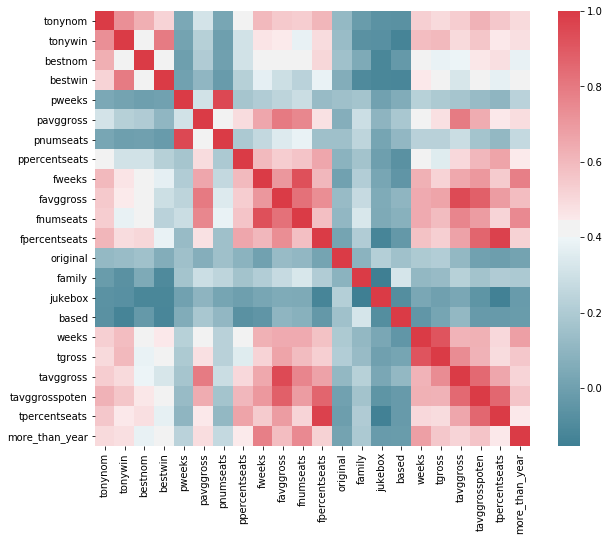

In [66]:
corr_matrix(df[first_run+y_vars])

In [80]:
second_run = ['tonynom', 'tonywin', 'bestnom', 'bestwin',
        'pavggross', 'pnumseats', 'ppercentseats', 'pnum',
         'favggross',  'fnumseats', 'fpercentseats', 'fnum',
       'original', 'family', 'jukebox', 'based']

In [68]:
essential_vars = ['tonynom', 'tonywin', 'bestnom', 'bestwin',
        'pweeks', 'pavggross', 'ptotalseats', 'pnum', 
         'fweeks', 'favggross']

genre = ['revival','family', 'jukebox', 'based']

# Weeks

AxesSubplot(0.125,0.125;0.775x0.755)


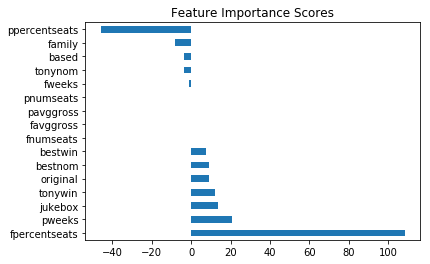

In [202]:
y = df['weeks']
X1, X2 = df[first_run], df[second_run]
fi1 = feature_importance(X1, y)

AxesSubplot(0.125,0.125;0.775x0.755)


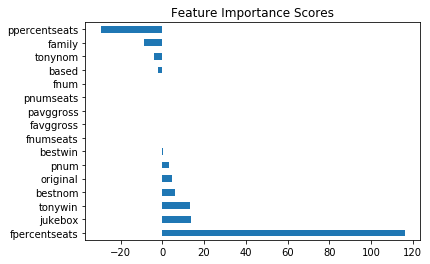

In [203]:
X2 = df[second_run]
fi2 = feature_importance(X2, y)

In [222]:
fit_linear_regression('weeks',   
            var_lists = [first_run, second_run, fi1, fi2])

                         0            1            2            3
rsquared          0.631245     0.659294     0.595574     0.599297
Intercept         -81.5247     -87.5826     -60.1435     -56.0339
tonynom           -3.80509      -3.9351          NaN          NaN
tonywin            12.3252      13.1864      9.38361      10.1253
bestnom            8.84728      5.90204      2.42909      2.76302
bestwin            7.77436     0.286944      8.42162          NaN
original           9.14787      4.58508      10.3397      10.3881
family            -8.46205     -8.76572          NaN          NaN
jukebox            13.5679      13.5927      12.6467      10.7023
based             -3.87856      -2.0221          NaN     -4.63276
pweeks             20.8825          NaN      3.03746          NaN
pavggross     -3.96073e-05 -4.89562e-05 -6.26204e-05 -6.49449e-05
pnumseats      -0.00165192  -0.00184984          NaN          NaN
ppercentseats      -45.942     -29.5425          NaN          NaN
pnum      

/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Total Gross Revenue

AxesSubplot(0.125,0.125;0.775x0.755)


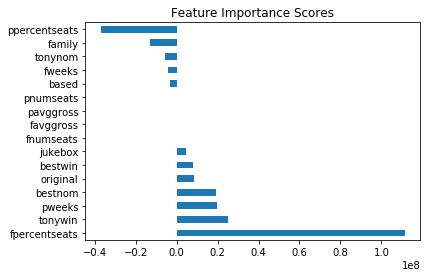

In [223]:
y = df['tgross']
X1, X2 = df[first_run], df[second_run]
fi1 = feature_importance(X1, y)

AxesSubplot(0.125,0.125;0.775x0.755)


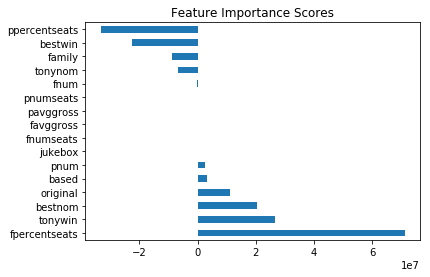

In [224]:
X2 = df[second_run]
fi2 = feature_importance(X2, y)

In [225]:
fit_linear_regression('tgross',   
            var_lists = [first_run, second_run, fi1, fi2])

                         0            1            2            3
rsquared          0.618203      0.61868     0.577775     0.579257
Intercept     -9.99373e+07  -9.4814e+07 -5.31058e+07 -5.35406e+07
tonynom       -5.88859e+06 -6.67979e+06          NaN          NaN
tonywin        2.52348e+07  2.67535e+07  1.86587e+07  1.79501e+07
bestnom        1.93949e+07  2.04299e+07  4.57924e+06  3.17398e+06
bestwin         7.7912e+06 -2.26493e+07 -7.06148e+06          NaN
original       8.63067e+06  1.11911e+07  2.07889e+07  2.00967e+07
family        -1.28888e+07 -8.79616e+06          NaN          NaN
jukebox        4.49602e+06      51460.2 -8.53574e+06  -8.1137e+06
based         -3.05575e+06  3.28435e+06          NaN   1.2583e+06
pweeks         1.95536e+07          NaN  2.62788e+06          NaN
pavggross          19.9018      1.97229     -19.3479      -24.407
pnumseats         -1618.69     -1494.03          NaN          NaN
ppercentseats -3.71093e+07 -3.32776e+07          NaN          NaN
pnum      

/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Other Y Variables

In [226]:
y_vars

['weeks',
 'tgross',
 'tavggross',
 'tavggrosspoten',
 'tpercentseats',
 'more_than_year']



 weeks 

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
                         0            1            2            3
rsquared          0.631245     0.659294     0.579816     0.581101
Intercept         -81.5247     -87.5826     -79.7318     -79.6952
tonynom           -3.80509      -3.9351          NaN          NaN
tonywin            12.3252      13.1864      10.3368      10.4513
bestnom            8.84728      5.90204      7.61169      7.33077
bestwin            7.77436     0.286944      6.60006      5.79487
original           9.14787      4.58508      11.4584      11.1444
family            -8.46205     -8.76572          NaN          NaN
jukebox            13.5679      13.5927      12.1416      11.7876
based             -3.87856      -2.0221          NaN          NaN
pweeks             20.8825          NaN      2.59674          NaN
pavggross     -3.96073e-05 -4.89562e-05          NaN          NaN
pnumseats      -0.00165192  -0.00184984          NaN     

/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  



                         0            1            2            3
rsquared          0.618203      0.61868     0.577775     0.579257
Intercept     -9.99373e+07  -9.4814e+07 -5.31058e+07 -5.35406e+07
tonynom       -5.88859e+06 -6.67979e+06          NaN          NaN
tonywin        2.52348e+07  2.67535e+07  1.86587e+07  1.79501e+07
bestnom        1.93949e+07  2.04299e+07  4.57924e+06  3.17398e+06
bestwin         7.7912e+06 -2.26493e+07 -7.06148e+06          NaN
original       8.63067e+06  1.11911e+07  2.07889e+07  2.00967e+07
family        -1.28888e+07 -8.79616e+06          NaN          NaN
jukebox        4.49602e+06      51460.2 -8.53574e+06  -8.1137e+06
based         -3.05575e+06  3.28435e+06          NaN   1.2583e+06
pweeks         1.95536e+07          NaN  2.62788e+06          NaN
pavggross          19.9018      1.97229     -19.3479      -24.407
pnumseats         -1618.69     -1494.03          NaN          NaN
ppercentseats -3.71093e+07 -3.32776e+07          NaN          NaN
pnum     

/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


                         0            1            2            3
rsquared          0.930733     0.941414     0.903511     0.906378
Intercept        -0.199439    -0.177912    -0.233531    -0.206682
tonynom        -0.00314592  -0.00163145          NaN          NaN
tonywin         0.00873746   0.00575304    0.0101087   0.00454931
bestnom         0.00101226   -0.0107008   -0.0135343          NaN
bestwin         -0.0177612    0.0148641          NaN    0.0387681
original        -0.0119772   -0.0120941          NaN          NaN
family         -0.00687233   -0.0107839          NaN          NaN
jukebox         -0.0218418    -0.027925          NaN          NaN
based          -0.00131395  -0.00837618          NaN          NaN
pweeks          0.00158659          NaN   -0.0056516          NaN
pavggross       9.0904e-09 -2.07257e-08  1.72366e-08          NaN
pnumseats       -4.392e-07 -4.54116e-07          NaN          NaN
ppercentseats    0.0268978      0.03453   0.00532495  -0.00516192
pnum      

/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


                         0            1            2            3
rsquared          0.661833     0.671901     0.637288     0.632615
Intercept        -0.410828    -0.409394    -0.335667    -0.293743
tonynom          -0.017017   -0.0151083          NaN          NaN
tonywin          0.0290634    0.0262853   0.00943549   0.00872071
bestnom         0.00549108   -0.0302146   -0.0246699          NaN
bestwin           0.250171     0.273154      0.25721     0.305195
original        -0.0676342   -0.0858443          NaN          NaN
family           0.0030935   0.00115314    0.0227036   0.00684178
jukebox          0.0398818    0.0280219    -0.029704   -0.0367148
based            0.0230297     0.020727  2.33167e-05   -0.0221954
pweeks           0.0695594          NaN    0.0143892          NaN
pavggross     -1.41288e-07  -2.2779e-07          NaN          NaN
pnumseats     -4.81286e-06 -7.32261e-06          NaN          NaN
ppercentseats    -0.210836    -0.147475          NaN          NaN
pnum      

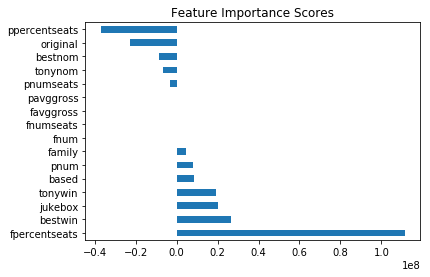

In [230]:
for var in y_vars:
    print('\n\n',var, '\n')
    y = df[var]
    X1, X2 = df[first_run], df[second_run]
    fi1, fi2 = feature_importance(X1, y), feature_importance(X2, y)
    fit_linear_regression(var ,
            var_lists = [first_run, second_run, fi1, fi2])

# Random Forest Regression

In [297]:
x_vars = [c for c in df.columns if c not in y_vars]
x = df[x_vars]
y = df[y_vars]

In [298]:
## Standardize the data
## First, drop all rows for which the standard deviation is 0 (containing NaN)
for i in x.index:
    if x.T.std()[i] == 0:
        
        x.drop(i,inplace=True)
        y.drop(i,inplace=True)
        
## Standardize the data by each feature, so that each feature has 
## mean zero and standard deviation = 1
x = ((x - x.mean()) / x.std())

In [299]:
weeks = y['weeks']
tgross = y['tgross']
tavggross = y['tavggross']
tavggrosspoten = y['tavggrosspoten']
tpercentseats = y['tpercentseats']
more_than_year = y['more_than_year']

### Weeks

Random Forest diagnostic score for training data: 0.8439005037059757
Random Forest diagnostic score for testing data: 0.7848991380931503
AxesSubplot(0.125,0.125;0.775x0.755)


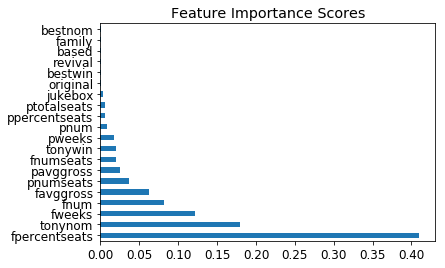

In [310]:
## Train-test split the data to have 1/3 test size and 2/3 train size
X_train, X_test, y_train, y_test = train_test_split(x, weeks, 
                                                    test_size=0.1, 
                                                    random_state=42)
# Supervised transformation based on random forests
rf = rfr(max_depth=None, n_estimators=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('Random Forest diagnostic score for training data:',
      rf.score(X_train, y_train))
print('Random Forest diagnostic score for testing data:',
      rf.score(X_test, y_test))

matplotlib.rcParams.update({'font.size': 12})

importances = rf.feature_importances_
print(pd.Series(importances, index=x.columns)
   .nlargest(20)
   .plot(kind='barh' , title = 'Feature Importance Scores'))

## Revenue (tgross)

Random Forest diagnostic score for training data: 0.852733600190511
Random Forest diagnostic score for testing data: 0.8861392530073811
AxesSubplot(0.125,0.125;0.775x0.755)


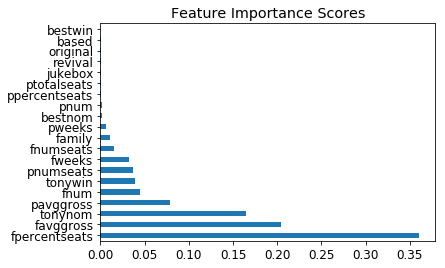

In [309]:
## Train-test split the data to have 1/3 test size and 2/3 train size
X_train, X_test, y_train, y_test = train_test_split(x, tgross, 
                                                    test_size=0.1, 
                                                    random_state=42)
# Supervised transformation based on random forests
rf = rfr(max_depth=None, n_estimators=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('Random Forest diagnostic score for training data:',
      rf.score(X_train, y_train))
print('Random Forest diagnostic score for testing data:',
      rf.score(X_test, y_test))

matplotlib.rcParams.update({'font.size': 12})

importances = rf.feature_importances_
print(pd.Series(importances, index=x.columns)
   .nlargest(20)
   .plot(kind='barh' , title = 'Feature Importance Scores'))

## More Than 1 Year (more_than_year)

Random Forest diagnostic score for training data: 0.9953571428571428
Random Forest diagnostic score for testing data: 0.9938888888888889
AxesSubplot(0.125,0.125;0.775x0.755)


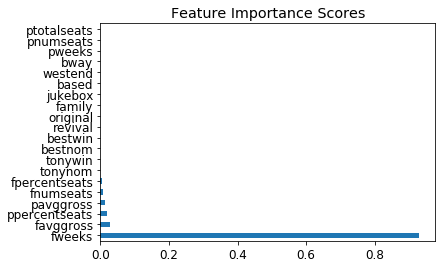

In [308]:
## Train-test split the data to have 1/3 test size and 2/3 train size
X_train, X_test, y_train, y_test = train_test_split(x, more_than_year, 
                                                    test_size=0.1, 
                                                    random_state=42)

# Supervised transformation based on random forests
rf = rfr(max_depth=None, n_estimators=10)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print('Random Forest diagnostic score for training data:',
      rf.score(X_train, y_train))
print('Random Forest diagnostic score for testing data:',
      rf.score(X_test, y_test))

importances = rf.feature_importances_
print(pd.Series(importances, index=x.columns)
   .nlargest(20)
   .plot(kind='barh' , title = 'Feature Importance Scores'))